In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb

In [3]:
#all_data = pd.read_csv('data/all_added_encoded_vectorized.csv')
#all_new = pd.read_csv('data/all_region_added_encoded_shortvectorized.csv')
all_new = pd.read_csv('data/all_df_nlp_preprocessed.csv')
sub = pd.read_csv('data/sample_submit.csv')

In [4]:
all_new.columns

Index(['id', 'goal', 'country', 'duration', 'category1', 'category2',
       'html_content', 'state', 'data_type', 'region', 'goal_min', 'goal_max',
       'range/min', 'max/min', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', 'html_raw', 'number_of_figure',
       'number_of_video', 'number_of_paragraph', 'length_of_text', 'video',
       'selected_paragraphs'],
      dtype='object')

In [5]:
def run_optuna_lgbm(test, train, target_cols, feature_cols, categorical_cols):
    """
    import optuna.integration.lightgbm as lgb
    """
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train.loc[train_index]
        y_val = y_train.loc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=100,
                          early_stopping_rounds=5,
                          )
        
        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
        display(importance)

    return oof_train, sum(y_preds) / len(y_preds)

In [13]:
target_cols = ["state"]
feature_cols = ["country", "category1", "duration", "goal_min", 'number_of_figure', 'number_of_paragraph', 'length_of_text']
categorical_cols = ["country", "category1"]
vector = list(map(str, range(25)))
feature_cols.extend(vector)
print(feature_cols)
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }

['country', 'category1', 'duration', 'goal_min', 'number_of_figure', 'number_of_paragraph', 'length_of_text', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


In [14]:
"""
TO DO:

region 以外にcountry関連の特徴量が欲しい．

"""

'\nTO DO:\n\nregion 以外にcountry関連の特徴量が欲しい．\n\n'

In [15]:
# run optuna lgbm with region, category1(vectorized)
test_set = all_new[all_new["data_type"] == "test"]
train_set = all_new[all_new["data_type"] == "train"]
_oof2, _preds2 = run_optuna_lgbm(test_set, train_set, target_cols, feature_cols, categorical_cols)

[I 2020-12-26 22:01:06,752] A new study created in memory with name: no-name-c84bc491-7424-4696-9c34-de90939e6981
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction, val_score: 0.435439:  14%|#4        | 1/7 [00:00<00:02,  2.91it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction, val_score: 0.435439:  29%|##8       | 2/7 [00:00<00:01,  2.86it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction, val_score: 0.433056:  43%|####2     | 3/7 [00:01<00:01,  2.73it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction, val_score: 0.433056:  57%|#####7    | 4/7 [00:01<00:01,  2.55it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction, val_score: 0.433056:  71%|#######1  | 5/7 [00:02<00:00,  2.46it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction, val_score: 0.433056:  86%|########5 | 6/7 [00:02<00:00,  2.40it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:   5%|5         | 1/20 [00:00<00:09,  2.04it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  10%|#         | 2/20 [00:00<00:08,  2.03it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  15%|#5        | 3/20 [00:01<00:08,  2.05it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  20%|##        | 4/20 [00:02<00:09,  1.69it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  25%|##5       | 5/20 [00:03<00:09,  1.56it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  30%|###       | 6/20 [00:03<00:08,  1.59it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  35%|###5      | 7/20 [00:04<00:07,  1.71it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  40%|####      | 8/20 [00:04<00:06,  1.79it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  45%|####5     | 9/20 [00:05<00:07,  1.54it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  50%|#####     | 10/20 [00:06<00:06,  1.48it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  55%|#####5    | 11/20 [00:06<00:05,  1.63it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  65%|######5   | 13/20 [00:07<00:03,  1.89it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  70%|#######   | 14/20 [00:08<00:03,  1.71it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  75%|#######5  | 15/20 [00:09<00:02,  1.71it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  80%|########  | 16/20 [00:09<00:02,  1.84it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  85%|########5 | 17/20 [00:09<00:01,  1.87it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  90%|######### | 18/20 [00:10<00:01,  1.88it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


num_leaves, val_score: 0.433056:  95%|#########5| 19/20 [00:11<00:00,  1.83it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  10%|#         | 1/10 [00:00<00:03,  2.73it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  30%|###       | 3/10 [00:00<00:02,  3.06it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  40%|####      | 4/10 [00:01<00:02,  2.94it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  50%|#####     | 5/10 [00:01<00:01,  2.85it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  60%|######    | 6/10 [00:02<00:01,  2.84it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  70%|#######   | 7/10 [00:02<00:01,  2.71it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  80%|########  | 8/10 [00:02<00:00,  2.72it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


bagging, val_score: 0.433056:  90%|######### | 9/10 [00:03<00:00,  2.74it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction_stage2, val_score: 0.433056:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction_stage2, val_score: 0.433056:  33%|###3      | 1/3 [00:00<00:00,  2.64it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


feature_fraction_stage2, val_score: 0.433056:  67%|######6   | 2/3 [00:00<00:00,  2.68it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:   5%|5         | 1/20 [00:00<00:07,  2.59it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  10%|#         | 2/20 [00:00<00:07,  2.53it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  15%|#5        | 3/20 [00:01<00:06,  2.52it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  20%|##        | 4/20 [00:01<00:06,  2.48it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  25%|##5       | 5/20 [00:02<00:06,  2.47it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  30%|###       | 6/20 [00:02<00:05,  2.41it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  35%|###5      | 7/20 [00:02<00:05,  2.41it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  40%|####      | 8/20 [00:03<00:05,  2.26it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  45%|####5     | 9/20 [00:03<00:04,  2.28it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  50%|#####     | 10/20 [00:04<00:04,  2.33it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  55%|#####5    | 11/20 [00:04<00:03,  2.34it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  60%|######    | 12/20 [00:05<00:03,  2.37it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  65%|######5   | 13/20 [00:05<00:02,  2.37it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  70%|#######   | 14/20 [00:05<00:02,  2.39it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  75%|#######5  | 15/20 [00:06<00:02,  2.38it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  80%|########  | 16/20 [00:06<00:01,  2.38it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  85%|########5 | 17/20 [00:07<00:01,  2.37it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  90%|######### | 18/20 [00:07<00:00,  2.37it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


regularization_factors, val_score: 0.433056:  95%|#########5| 19/20 [00:08<00:00,  2.37it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


min_data_in_leaf, val_score: 0.433056:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


min_data_in_leaf, val_score: 0.433056:  20%|##        | 1/5 [00:00<00:01,  2.78it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


min_data_in_leaf, val_score: 0.433056:  40%|####      | 2/5 [00:00<00:01,  2.58it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


min_data_in_leaf, val_score: 0.433056:  60%|######    | 3/5 [00:01<00:00,  2.55it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


min_data_in_leaf, val_score: 0.433056:  80%|########  | 4/5 [00:01<00:00,  2.56it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328


min_data_in_leaf, val_score: 0.433056: 100%|##########| 5/5 [00:02<00:00,  2.40it/s]


,importance
country,58
category1,89
duration,194
goal_min,253
number_of_figure,191
number_of_paragraph,159
length_of_text,313
0,67
1,83
2,69


[I 2020-12-26 22:01:36,413] A new study created in memory with name: no-name-8db33938-7f17-472b-98f0-8d6af0720ec3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction, val_score: 0.465004:  14%|#4        | 1/7 [00:00<00:02,  2.72it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction, val_score: 0.464360:  43%|####2     | 3/7 [00:00<00:01,  3.14it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction, val_score: 0.464360:  57%|#####7    | 4/7 [00:01<00:00,  3.39it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction, val_score: 0.461627:  71%|#######1  | 5/7 [00:01<00:00,  3.32it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction, val_score: 0.461627:  86%|########5 | 6/7 [00:01<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.461627:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.461627:   5%|5         | 1/20 [00:00<00:06,  2.72it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.461627:  10%|#         | 2/20 [00:00<00:06,  2.81it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.461627:  15%|#5        | 3/20 [00:01<00:06,  2.82it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.461627:  20%|##        | 4/20 [00:01<00:06,  2.60it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  30%|###       | 6/20 [00:02<00:04,  3.15it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  35%|###5      | 7/20 [00:02<00:03,  3.56it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32


num_leaves, val_score: 0.458303:  40%|####      | 8/20 [00:02<00:03,  3.82it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  45%|####5     | 9/20 [00:02<00:02,  4.07it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  50%|#####     | 10/20 [00:02<00:02,  3.63it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  60%|######    | 12/20 [00:03<00:02,  3.44it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  65%|######5   | 13/20 [00:04<00:02,  2.88it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  70%|#######   | 14/20 [00:04<00:02,  2.75it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.458303:  75%|#######5  | 15/20 [00:04<00:01,  2.87it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.457719:  80%|########  | 16/20 [00:05<00:01,  3.03it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.457719:  90%|######### | 18/20 [00:05<00:00,  3.26it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


num_leaves, val_score: 0.457719:  95%|#########5| 19/20 [00:06<00:00,  2.61it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457719:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457719:  10%|#         | 1/10 [00:00<00:05,  1.76it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457719:  20%|##        | 2/10 [00:01<00:04,  1.87it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457719:  30%|###       | 3/10 [00:01<00:03,  1.96it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457393:  40%|####      | 4/10 [00:02<00:03,  1.86it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457393:  50%|#####     | 5/10 [00:02<00:02,  2.04it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457393:  60%|######    | 6/10 [00:02<00:01,  2.34it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457393:  70%|#######   | 7/10 [00:03<00:01,  2.51it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


bagging, val_score: 0.457393:  80%|########  | 8/10 [00:03<00:00,  2.78it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction_stage2, val_score: 0.457393:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction_stage2, val_score: 0.457393:  33%|###3      | 1/3 [00:00<00:00,  4.15it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


feature_fraction_stage2, val_score: 0.457393:  67%|######6   | 2/3 [00:00<00:00,  3.80it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:   5%|5         | 1/20 [00:00<00:05,  3.29it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  10%|#         | 2/20 [00:00<00:05,  3.26it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  15%|#5        | 3/20 [00:00<00:05,  3.24it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  20%|##        | 4/20 [00:01<00:04,  3.22it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  25%|##5       | 5/20 [00:01<00:04,  3.31it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  30%|###       | 6/20 [00:01<00:04,  3.15it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  35%|###5      | 7/20 [00:02<00:04,  3.10it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  40%|####      | 8/20 [00:02<00:03,  3.23it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  45%|####5     | 9/20 [00:02<00:03,  3.27it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  50%|#####     | 10/20 [00:03<00:03,  3.22it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  55%|#####5    | 11/20 [00:03<00:02,  3.28it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  60%|######    | 12/20 [00:03<00:02,  3.27it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  65%|######5   | 13/20 [00:04<00:02,  3.25it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  70%|#######   | 14/20 [00:04<00:01,  3.25it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  75%|#######5  | 15/20 [00:04<00:01,  3.23it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.457393:  80%|########  | 16/20 [00:04<00:01,  3.15it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.455861:  85%|########5 | 17/20 [00:05<00:00,  3.21it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.455547:  90%|######### | 18/20 [00:05<00:00,  3.05it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


regularization_factors, val_score: 0.455547:  95%|#########5| 19/20 [00:06<00:00,  2.99it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


min_data_in_leaf, val_score: 0.455547:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


min_data_in_leaf, val_score: 0.455547:  20%|##        | 1/5 [00:00<00:01,  3.37it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


min_data_in_leaf, val_score: 0.455547:  40%|####      | 2/5 [00:00<00:00,  3.25it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


min_data_in_leaf, val_score: 0.455547:  60%|######    | 3/5 [00:00<00:00,  3.32it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


min_data_in_leaf, val_score: 0.455547:  80%|########  | 4/5 [00:01<00:00,  3.05it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


min_data_in_leaf, val_score: 0.455547: 100%|##########| 5/5 [00:01<00:00,  3.09it/s]


,importance
country,50
category1,76
duration,107
goal_min,142
number_of_figure,118
number_of_paragraph,77
length_of_text,131
0,73
1,67
2,76


[I 2020-12-26 22:01:58,700] A new study created in memory with name: no-name-081966a8-41c7-492a-8120-d094527bab15
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction, val_score: 0.442094:  14%|#4        | 1/7 [00:00<00:02,  2.84it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction, val_score: 0.442094:  29%|##8       | 2/7 [00:00<00:01,  2.91it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction, val_score: 0.442094:  57%|#####7    | 4/7 [00:01<00:00,  3.27it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction, val_score: 0.442094:  71%|#######1  | 5/7 [00:01<00:00,  3.39it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


[I 2020-12-26 22:02:00,199] Trial 4 finished with value: 0.44431313651480275 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.44209422799223375.
feature_fraction, val_score: 0.442094:  86%|########5 | 6/7 [00:01<00:00,  3.65it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.442094:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.442094:   5%|5         | 1/20 [00:00<00:08,  2.31it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.442094:  10%|#         | 2/20 [00:00<00:07,  2.28it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.441644:  20%|##        | 4/20 [00:01<00:06,  2.45it/s][I 2020-12-26 22:02:02,429] Trial 10 finished with value: 0.44164421861839465 and parameters: {'num_leaves': 10}. Best is trial 10 with value: 0.44164421861839465.


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.441644:  20%|##        | 4/20 [00:01<00:06,  2.45it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  30%|###       | 6/20 [00:02<00:04,  2.90it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  35%|###5      | 7/20 [00:02<00:03,  3.26it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  40%|####      | 8/20 [00:02<00:03,  3.10it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  45%|####5     | 9/20 [00:03<00:03,  2.87it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  55%|#####5    | 11/20 [00:03<00:03,  2.95it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  65%|######5   | 13/20 [00:04<00:02,  3.05it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  70%|#######   | 14/20 [00:05<00:02,  2.79it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  75%|#######5  | 15/20 [00:05<00:01,  2.71it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  80%|########  | 16/20 [00:05<00:01,  2.70it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  85%|########5 | 17/20 [00:06<00:01,  2.46it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  90%|######### | 18/20 [00:06<00:00,  2.58it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


num_leaves, val_score: 0.440783:  95%|#########5| 19/20 [00:07<00:00,  2.48it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.440783:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.440783:  10%|#         | 1/10 [00:00<00:03,  2.86it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.440783:  20%|##        | 2/10 [00:00<00:02,  2.90it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.440783:  30%|###       | 3/10 [00:00<00:02,  3.01it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.439169:  40%|####      | 4/10 [00:01<00:02,  2.96it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.439053:  60%|######    | 6/10 [00:01<00:01,  3.21it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.439053:  70%|#######   | 7/10 [00:02<00:00,  3.11it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.439053:  80%|########  | 8/10 [00:02<00:00,  3.06it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.439053: 100%|##########| 10/10 [00:03<00:00,  3.19it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


[I 2020-12-26 22:02:11,534] Trial 36 finished with value: 0.44599798749453656 and parameters: {'bagging_fraction': 0.9013551150837144, 'bagging_freq': 3}. Best is trial 31 with value: 0.43905320579277557.
feature_fraction_stage2, val_score: 0.439053:  17%|#6        | 1/6 [00:00<00:01,  3.78it/s][I 2020-12-26 22:02:11,809] Trial 37 finished with value: 0.44137334896263325 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.44137334896263325.


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction_stage2, val_score: 0.439053:  17%|#6        | 1/6 [00:00<00:01,  3.78it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction_stage2, val_score: 0.439053:  33%|###3      | 2/6 [00:00<00:01,  3.69it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction_stage2, val_score: 0.439053:  67%|######6   | 4/6 [00:01<00:00,  3.66it/s][I 2020-12-26 22:02:12,651] Trial 40 finished with value: 0.4434179406009173 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 39 with value: 0.4406661539466924.


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction_stage2, val_score: 0.439053:  67%|######6   | 4/6 [00:01<00:00,  3.66it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


feature_fraction_stage2, val_score: 0.439053:  83%|########3 | 5/6 [00:01<00:00,  3.42it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:   5%|5         | 1/20 [00:00<00:06,  2.74it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  10%|#         | 2/20 [00:00<00:06,  2.80it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  15%|#5        | 3/20 [00:01<00:06,  2.78it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  20%|##        | 4/20 [00:01<00:05,  2.77it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  25%|##5       | 5/20 [00:01<00:05,  2.79it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  30%|###       | 6/20 [00:02<00:05,  2.70it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  35%|###5      | 7/20 [00:02<00:04,  2.74it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  40%|####      | 8/20 [00:02<00:04,  2.77it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  45%|####5     | 9/20 [00:03<00:03,  2.77it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  50%|#####     | 10/20 [00:03<00:03,  2.79it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  55%|#####5    | 11/20 [00:03<00:03,  2.80it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  60%|######    | 12/20 [00:04<00:02,  2.79it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  65%|######5   | 13/20 [00:04<00:02,  2.68it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  70%|#######   | 14/20 [00:05<00:02,  2.72it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  75%|#######5  | 15/20 [00:05<00:01,  2.77it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  80%|########  | 16/20 [00:05<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  85%|########5 | 17/20 [00:06<00:01,  2.89it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  90%|######### | 18/20 [00:06<00:00,  2.88it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.439053:  95%|#########5| 19/20 [00:06<00:00,  2.88it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


min_data_in_leaf, val_score: 0.439053:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


min_data_in_leaf, val_score: 0.439053:  20%|##        | 1/5 [00:00<00:01,  3.26it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


min_data_in_leaf, val_score: 0.439053:  40%|####      | 2/5 [00:00<00:00,  3.05it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


min_data_in_leaf, val_score: 0.439053:  80%|########  | 4/5 [00:01<00:00,  3.10it/s][I 2020-12-26 22:02:21,778] Trial 66 finished with value: 0.4411088004443505 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.44058042211616777.


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


min_data_in_leaf, val_score: 0.439053:  80%|########  | 4/5 [00:01<00:00,  3.10it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3986
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


min_data_in_leaf, val_score: 0.439053: 100%|##########| 5/5 [00:01<00:00,  3.00it/s]


,importance
country,47
category1,75
duration,97
goal_min,127
number_of_figure,125
number_of_paragraph,70
length_of_text,124
0,47
1,48
2,50


[I 2020-12-26 22:02:22,195] A new study created in memory with name: no-name-89b888d5-ce57-4198-bc17-6362394a26ab
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction, val_score: 0.442405:  14%|#4        | 1/7 [00:00<00:02,  2.85it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction, val_score: 0.442405:  29%|##8       | 2/7 [00:00<00:01,  2.91it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction, val_score: 0.440269:  43%|####2     | 3/7 [00:00<00:01,  3.05it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction, val_score: 0.440269:  57%|#####7    | 4/7 [00:01<00:00,  3.19it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction, val_score: 0.440269:  71%|#######1  | 5/7 [00:01<00:00,  2.97it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction, val_score: 0.440269:  86%|########5 | 6/7 [00:02<00:00,  2.92it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:   5%|5         | 1/20 [00:00<00:08,  2.25it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  10%|#         | 2/20 [00:00<00:07,  2.29it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  15%|#5        | 3/20 [00:01<00:07,  2.36it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  25%|##5       | 5/20 [00:02<00:05,  2.54it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  30%|###       | 6/20 [00:02<00:04,  2.98it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[Ligh

num_leaves, val_score: 0.439540:  35%|###5      | 7/20 [00:02<00:05,  2.45it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  40%|####      | 8/20 [00:03<00:05,  2.32it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  45%|####5     | 9/20 [00:03<00:04,  2.41it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  50%|#####     | 10/20 [00:04<00:04,  2.37it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  55%|#####5    | 11/20 [00:04<00:03,  2.33it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  60%|######    | 12/20 [00:04<00:03,  2.54it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  65%|######5   | 13/20 [00:05<00:02,  2.45it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  70%|#######   | 14/20 [00:05<00:02,  2.32it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  75%|#######5  | 15/20 [00:06<00:02,  2.36it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  80%|########  | 16/20 [00:06<00:01,  2.37it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  85%|########5 | 17/20 [00:06<00:01,  2.58it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  90%|######### | 18/20 [00:07<00:00,  2.48it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


num_leaves, val_score: 0.439540:  95%|#########5| 19/20 [00:07<00:00,  2.46it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.439540:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.439540:  10%|#         | 1/10 [00:00<00:03,  2.92it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.439098:  20%|##        | 2/10 [00:00<00:02,  2.86it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.439098:  30%|###       | 3/10 [00:01<00:02,  2.74it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.438667:  50%|#####     | 5/10 [00:01<00:01,  2.58it/s][I 2020-12-26 22:02:34,706] Trial 31 finished with value: 0.44357431548480114 and parameters: {'bagging_fraction': 0.9688008136694204, 'bagging_freq': 7}. Best is trial 30 with value: 0.4386671086721484.


[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.438667:  60%|######    | 6/10 [00:02<00:01,  2.86it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.438667:  70%|#######   | 7/10 [00:02<00:00,  3.10it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.438667:  80%|########  | 8/10 [00:02<00:00,  3.13it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


bagging, val_score: 0.438667: 100%|##########| 10/10 [00:03<00:00,  3.28it/s][I 2020-12-26 22:02:36,119] Trial 36 finished with value: 0.4427331554454465 and parameters: {'bagging_fraction': 0.6470633592366535, 'bagging_freq': 6}. Best is trial 30 with value: 0.4386671086721484.


[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction_stage2, val_score: 0.438667:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction_stage2, val_score: 0.437143:  17%|#6        | 1/6 [00:00<00:01,  2.68it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction_stage2, val_score: 0.437143:  33%|###3      | 2/6 [00:00<00:01,  2.75it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction_stage2, val_score: 0.437143:  50%|#####     | 3/6 [00:01<00:01,  2.73it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction_stage2, val_score: 0.437143:  67%|######6   | 4/6 [00:01<00:00,  2.73it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


feature_fraction_stage2, val_score: 0.437143:  83%|########3 | 5/6 [00:01<00:00,  2.76it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:   5%|5         | 1/20 [00:00<00:06,  3.01it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  10%|#         | 2/20 [00:00<00:06,  2.96it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  15%|#5        | 3/20 [00:01<00:05,  2.86it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  20%|##        | 4/20 [00:01<00:05,  2.80it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  25%|##5       | 5/20 [00:01<00:05,  2.71it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  30%|###       | 6/20 [00:02<00:05,  2.66it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  35%|###5      | 7/20 [00:02<00:04,  2.68it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  40%|####      | 8/20 [00:02<00:04,  2.64it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  45%|####5     | 9/20 [00:03<00:04,  2.66it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  50%|#####     | 10/20 [00:03<00:03,  2.61it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  55%|#####5    | 11/20 [00:04<00:03,  2.54it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  60%|######    | 12/20 [00:04<00:03,  2.56it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  65%|######5   | 13/20 [00:04<00:02,  2.60it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  70%|#######   | 14/20 [00:05<00:02,  2.63it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  75%|#######5  | 15/20 [00:05<00:01,  2.65it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  80%|########  | 16/20 [00:06<00:01,  2.66it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  85%|########5 | 17/20 [00:06<00:01,  2.67it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  90%|######### | 18/20 [00:06<00:00,  2.64it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


regularization_factors, val_score: 0.437143:  95%|#########5| 19/20 [00:07<00:00,  2.60it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


min_data_in_leaf, val_score: 0.437143:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


min_data_in_leaf, val_score: 0.437143:  20%|##        | 1/5 [00:00<00:01,  2.62it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


min_data_in_leaf, val_score: 0.435240:  40%|####      | 2/5 [00:00<00:01,  2.61it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


min_data_in_leaf, val_score: 0.435240:  60%|######    | 3/5 [00:01<00:00,  2.63it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


min_data_in_leaf, val_score: 0.435240:  80%|########  | 4/5 [00:01<00:00,  2.55it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709


min_data_in_leaf, val_score: 0.435240: 100%|##########| 5/5 [00:01<00:00,  2.57it/s]


,importance
country,81
category1,111
duration,98
goal_min,171
number_of_figure,134
number_of_paragraph,92
length_of_text,181
0,82
1,65
2,79


[I 2020-12-26 22:02:47,945] A new study created in memory with name: no-name-9c9b0f5a-695e-4deb-8873-2a515e4d4e76
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction, val_score: 0.420551:  14%|#4        | 1/7 [00:00<00:02,  2.47it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction, val_score: 0.420551:  29%|##8       | 2/7 [00:00<00:01,  2.52it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction, val_score: 0.420551:  43%|####2     | 3/7 [00:01<00:01,  2.59it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction, val_score: 0.420551:  57%|#####7    | 4/7 [00:01<00:01,  2.52it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction, val_score: 0.419406:  71%|#######1  | 5/7 [00:01<00:00,  2.53it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction, val_score: 0.416536:  86%|########5 | 6/7 [00:02<00:00,  2.58it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.416536:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.416536:   5%|5         | 1/20 [00:00<00:09,  1.97it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.416536:  10%|#         | 2/20 [00:01<00:09,  1.94it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.416536:  15%|#5        | 3/20 [00:01<00:09,  1.87it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.416294:  25%|##5       | 5/20 [00:02<00:06,  2.29it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  35%|###5      | 7/20 [00:02<00:04,  2.73it/s][I 2020-12-26 22:02:53,620] Trial 13 finished with value: 0.4220905711921935 and parameters: {'num_leaves': 33}. Best is trial 12 with value: 0.41474175536378594.


[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  35%|###5      | 7/20 [00:02<00:04,  2.73it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  40%|####      | 8/20 [00:03<00:04,  2.53it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  50%|#####     | 10/20 [00:04<00:03,  2.83it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  55%|#####5    | 11/20 [00:04<00:03,  2.61it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  60%|######    | 12/20 [00:04<00:03,  2.50it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  65%|######5   | 13/20 [00:05<00:02,  2.42it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  70%|#######   | 14/20 [00:05<00:02,  2.26it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  80%|########  | 16/20 [00:06<00:01,  2.69it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  85%|########5 | 17/20 [00:06<00:00,  3.11it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  90%|######### | 18/20 [00:07<00:00,  2.78it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


num_leaves, val_score: 0.414742:  95%|#########5| 19/20 [00:07<00:00,  2.50it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  10%|#         | 1/10 [00:00<00:02,  3.31it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  20%|##        | 2/10 [00:00<00:02,  2.91it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  30%|###       | 3/10 [00:01<00:02,  2.78it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  40%|####      | 4/10 [00:01<00:02,  2.69it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  50%|#####     | 5/10 [00:01<00:01,  2.72it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  70%|#######   | 7/10 [00:02<00:01,  2.85it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  80%|########  | 8/10 [00:02<00:00,  2.86it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


bagging, val_score: 0.414574:  90%|######### | 9/10 [00:03<00:00,  2.84it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction_stage2, val_score: 0.414574:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction_stage2, val_score: 0.414574:  33%|###3      | 1/3 [00:00<00:00,  2.62it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


feature_fraction_stage2, val_score: 0.414574:  67%|######6   | 2/3 [00:00<00:00,  2.72it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414574:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:   5%|5         | 1/20 [00:00<00:07,  2.63it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  10%|#         | 2/20 [00:00<00:07,  2.55it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  15%|#5        | 3/20 [00:01<00:06,  2.43it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  20%|##        | 4/20 [00:01<00:06,  2.42it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  25%|##5       | 5/20 [00:02<00:06,  2.39it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  30%|###       | 6/20 [00:02<00:05,  2.49it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  35%|###5      | 7/20 [00:02<00:05,  2.46it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  40%|####      | 8/20 [00:03<00:04,  2.46it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  45%|####5     | 9/20 [00:03<00:04,  2.43it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  50%|#####     | 10/20 [00:04<00:04,  2.46it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  55%|#####5    | 11/20 [00:04<00:03,  2.47it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  60%|######    | 12/20 [00:04<00:03,  2.44it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  65%|######5   | 13/20 [00:05<00:02,  2.48it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  70%|#######   | 14/20 [00:05<00:02,  2.45it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  75%|#######5  | 15/20 [00:06<00:02,  2.48it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  80%|########  | 16/20 [00:06<00:01,  2.45it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  85%|########5 | 17/20 [00:06<00:01,  2.41it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  90%|######### | 18/20 [00:07<00:00,  2.45it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


regularization_factors, val_score: 0.414257:  95%|#########5| 19/20 [00:07<00:00,  2.42it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


min_data_in_leaf, val_score: 0.414257:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


min_data_in_leaf, val_score: 0.414257:  20%|##        | 1/5 [00:00<00:01,  2.36it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


min_data_in_leaf, val_score: 0.414257:  40%|####      | 2/5 [00:00<00:01,  2.34it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


min_data_in_leaf, val_score: 0.414257:  60%|######    | 3/5 [00:01<00:00,  2.33it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


min_data_in_leaf, val_score: 0.414257:  80%|########  | 4/5 [00:01<00:00,  2.40it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


min_data_in_leaf, val_score: 0.414257: 100%|##########| 5/5 [00:02<00:00,  2.35it/s]


,importance
country,74
category1,98
duration,128
goal_min,177
number_of_figure,147
number_of_paragraph,122
length_of_text,226
0,100
1,94
2,118


In [16]:
def optimize_accuracy(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        accuracyscore = accuracy_score(y_true=y_train, y_pred=oof_)
        scores.append(accuracyscore)
        best_score = max(best_score, accuracyscore)
        if accuracyscore == best_score:
            best_threshold = thr
    plt.figure()
    plt.title("accuracy_score")
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7834044570886676 0.47500000000000003


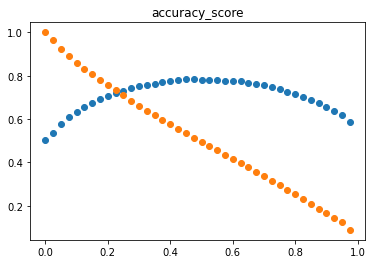

In [17]:
best_score2, best_threshold2 = optimize_accuracy(_oof2, list(train_set["state"]))
print(best_score2, best_threshold2)

In [18]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7923434893318114 0.4


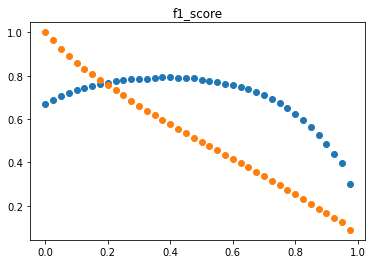

In [19]:
best_score2, best_threshold2 = optimize_threshold(_oof2, list(train_set["state"]))
print(best_score2, best_threshold2)

In [20]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

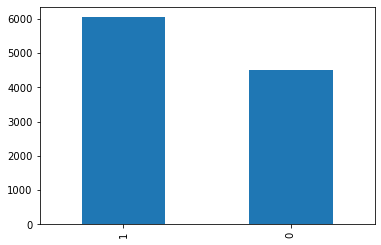

In [21]:
sub_file = making_sub(_preds2, 0.4)
sub_file.to_csv(f"sub_files/optuna_lgbm_sub_{10}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")